In [1]:
import torch as tr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import torchvision
from torch import nn
import requests
import zipfile
from pathlib import Path

## Data preparation and exploration

In [2]:
import os 
def walk_through_dir(dir_path):
    '''Walks through dir_path returning its contents.'''
    for dirpath, dirnames,  filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [3]:
image_path = Path('data/pizza_steak_sushi/')
walk_through_dir(image_path)

There are 2 directories and 0 images in data\pizza_steak_sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\test
There are 0 directories and 25 images in data\pizza_steak_sushi\test\pizza
There are 0 directories and 19 images in data\pizza_steak_sushi\test\steak
There are 0 directories and 31 images in data\pizza_steak_sushi\test\sushi
There are 3 directories and 0 images in data\pizza_steak_sushi\train
There are 0 directories and 78 images in data\pizza_steak_sushi\train\pizza
There are 0 directories and 75 images in data\pizza_steak_sushi\train\steak
There are 0 directories and 72 images in data\pizza_steak_sushi\train\sushi


## Setup train and testing paths

In [4]:
train_dir = f'{image_path}/train'
test_dir = f'{image_path}/test'

test_dir, train_dir

('data\\pizza_steak_sushi/test', 'data\\pizza_steak_sushi/train')

## Visualize and image

In [5]:
import random
from PIL import Image

# random.seed(42)

image_path_list = list(image_path.glob('*/*/*.jpg'))

random_image_path = random.choice(image_path_list)
random_image_path

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f'Random image path: {random_image_path}')
print(f'Image class {image_class}')
print(f'Image height: {img.height}')
print(f'Image width: {img.width}')

Random image path: data\pizza_steak_sushi\train\sushi\686426.jpg
Image class sushi
Image height: 512
Image width: 384


(-0.5, 383.5, 511.5, -0.5)

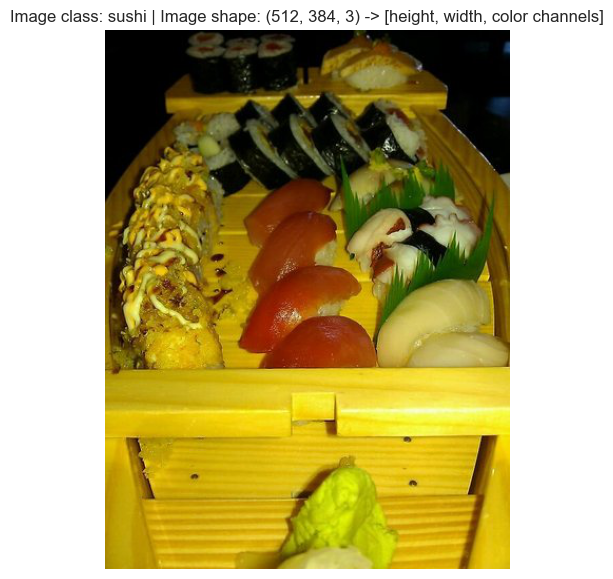

In [6]:
# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color channels]')
plt.axis(False)

## Transforming data

In [7]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [8]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [9]:
data_transform(img).shape

torch.Size([3, 64, 64])

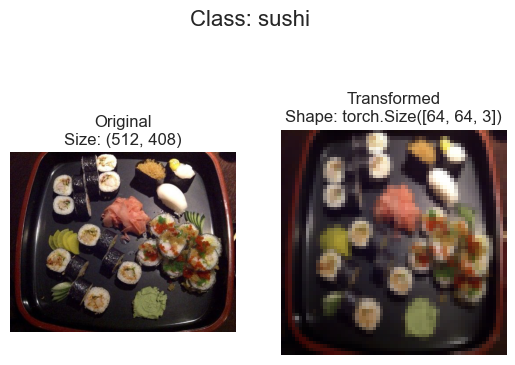

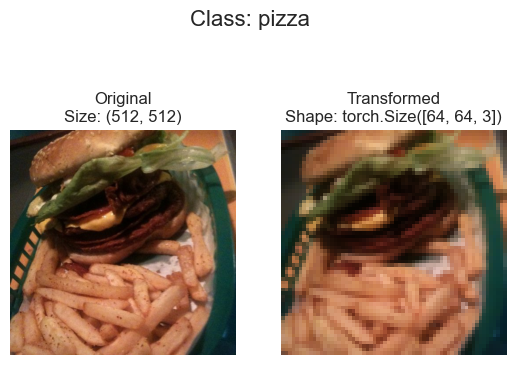

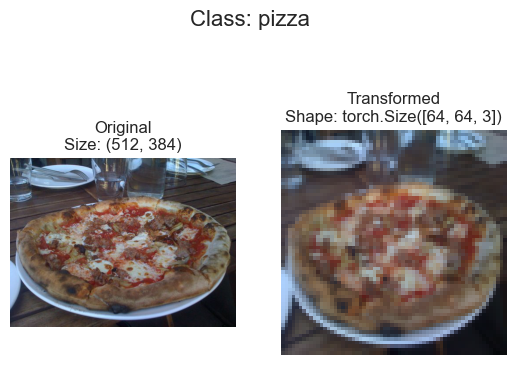

In [10]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    '''
    Selects random images from a path of images and loads/transforms
    them then plots the original vs the transformed version.
    '''
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original\nSize: {f.size}')
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
            ax[1].axis('off')

            fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        seed=42)

## Option 1: Loading image data using `ImageFolder`

In [11]:
# Use ImageFodler to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [12]:
# Get claas names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [13]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [14]:
# Check the lenght of our datasets
len(train_data), len(test_data)

(225, 75)

In [15]:
train_data.samples[0]

('data\\pizza_steak_sushi/train\\pizza\\1008844.jpg', 0)

In [16]:
# index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f'Image tensor: \n {img}')
print(f'image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label: {label}')
print(f'Label datatype: {type(label)}')

Image tensor: 
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.

Original shape: torch.Size([3, 64, 64])
Image permute: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

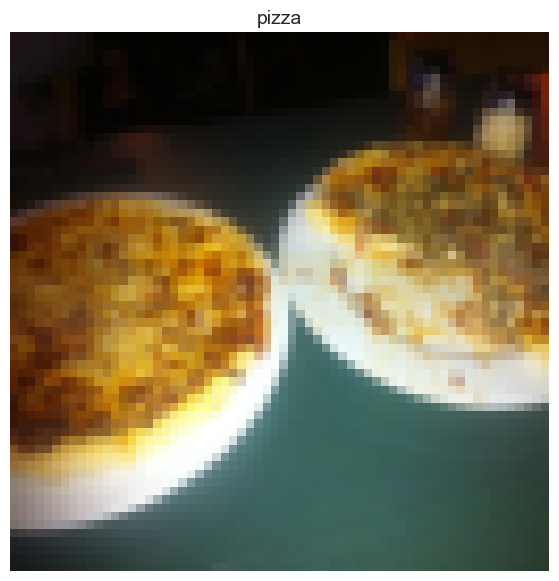

In [17]:
# Rearrange the order dimensions
img_permute = img.permute(1,2,0)

print(f'Original shape: {img.shape}')
print(f'Image permute: {img_permute.shape}')

# Plot image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis('off')
plt.title(class_names[label], fontsize=14)

In [18]:
# Turn train and test datasets into DataLoader's
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x17dfc0448b0>,
 <torch.utils.data.dataloader.DataLoader at 0x17dfc0ad720>)

In [19]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [20]:
img, label = next(iter(train_dataloader))

print(f'image shape: {img.shape}')
print(f'label shape: {label.shape}')

image shape: torch.Size([1, 3, 64, 64])
label shape: torch.Size([1])


## Option 2: Loading image data with a custom dataset

In [21]:
from torch.utils.data import Dataset
from typing import Tuple, Dict, List
import pathlib

In [22]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [23]:
target_directory = train_dir
print(f'Target dir: {target_directory}')

# Get class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data\pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [24]:
list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [25]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    '''Finds the class folder names in a target directory'''
    # Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

    # Create a dictionary of index labels
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
    return classes, class_to_idx

In [26]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## Creating a custom `Dataset` to replicate `ImageFolder`

In [27]:
# Writing a custom dataset class
# Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    def __init__(self,
                 targ_dir: str,
                 transform=None):
        # Create class attributes
        # Get all the image paths
        self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)

    # Overwrite __len__()
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # Overwrite __getitem__() method to return particular sample
    def __getitem__(self, index: int) -> Tuple[tr.Tensor, int]:
        "Returns one sample of data, data and label(X,y)"
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label(X,y)
        else:
            return img, class_idx # return untransformed image and label

In [28]:
# Create a transform 
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [29]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [30]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x17dfc0aca60>,
 <__main__.ImageFolderCustom at 0x17dfc0ad300>)

## Create a function to display random images

In [31]:
# Create a function 
def display_random_images(dataset: tr.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # Adjust display if n is too high
    if n > 10: 
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")

    # Set the seed
    if seed:
        random.seed(seed)

    # Get random sample indexes 
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # Setup plot
    plt.figure(figsize=(16,8))

    # Loop through the random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1,2,0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis('off')
        if classes:
            title = f'Class: {classes[targ_label]}'
            if display_shape:
                title =title + f'\nshape: {targ_image_adjust.shape}'
        plt.title(title)

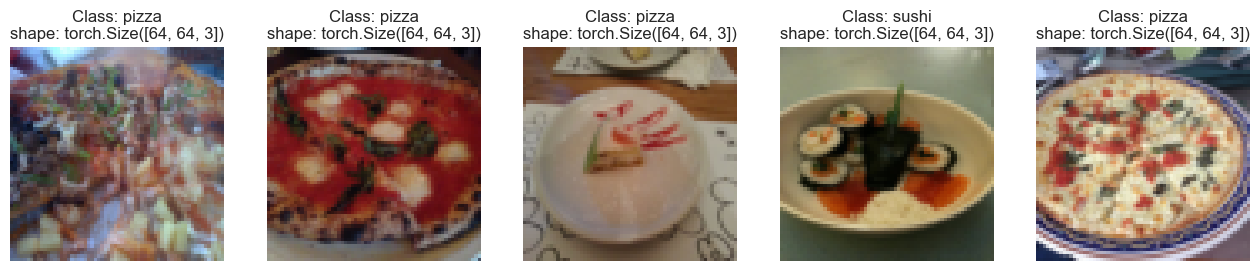

In [32]:
# Display random images from the image folder
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

## Turn custom loaded images into DataLoader's

In [33]:
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size = BATCH_SIZE,
                                    num_workers=0,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x17dfc0b8be0>,
 <torch.utils.data.dataloader.DataLoader at 0x17dfc0b9c00>)

In [34]:
# Get image and label form custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## Data augmentation

In [35]:
# trivialaugment
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [36]:
image_path

WindowsPath('data/pizza_steak_sushi')

In [37]:
# get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

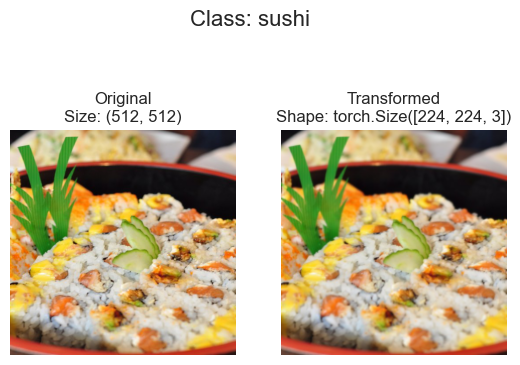

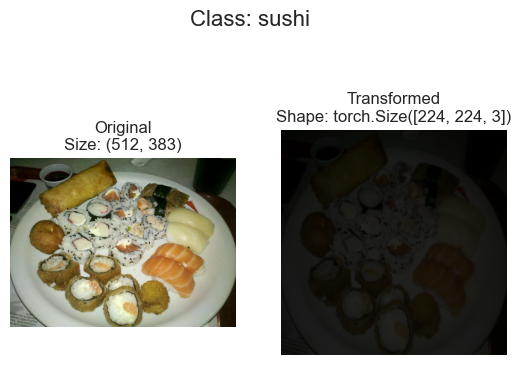

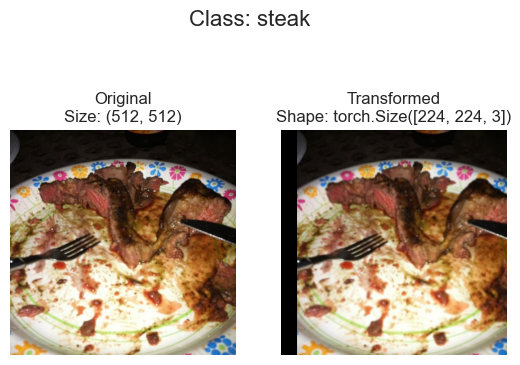

In [38]:
# plot random imgs
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None)

## Model 0: TinyVGG without data augmentation

In [39]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [40]:
# Load and transform data
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# Turn datasets into DataLoader
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create dataloaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)

In [41]:
## Create TinyVGG
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int,
                 hidden_units: int,
                 out_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2))
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=out_shape)
        )
    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits form operator fusion

In [42]:
tr.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  out_shape=len(class_names))

In [43]:
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

## Try a forward pass on a single image

In [44]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [45]:
model_0(image_batch)

tensor([[ 2.0789e-02, -1.9351e-03,  9.5317e-03],
        [ 1.8427e-02,  2.4670e-03,  6.6757e-03],
        [ 1.7699e-02,  1.0262e-03,  9.4657e-03],
        [ 2.4441e-02, -3.3526e-03,  9.6011e-03],
        [ 1.9930e-02,  6.6316e-04,  1.0779e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0999e-02,  1.2870e-04,  1.2473e-02],
        [ 2.1577e-02, -1.9507e-03,  9.6941e-03],
        [ 2.4504e-02, -4.7745e-03,  8.5280e-03],
        [ 2.0252e-02, -4.7294e-04,  1.0908e-02],
        [ 2.2215e-02, -4.1838e-04,  9.8123e-03],
        [ 2.2313e-02, -2.1622e-03,  9.4456e-03],
        [ 2.1841e-02, -3.7132e-03,  8.3783e-03],
        [ 2.2863e-02, -1.7724e-03,  1.0287e-02],
        [ 2.1647e-02, -4.4139e-03,  9.5021e-03],
        [ 2.2096e-02, -4.1426e-03,  9.3853e-03],
        [ 2.1209e-02, -4.4219e-03,  1.1475e-02],
        [ 2.1711e-02, -2.7656e-03,  8.5006e-03],
        [ 1.9951e-02,  2.8254e-05,  8.4380e-03],
        [ 1.8298e-02,  1.6306e-03,  8.5499e-03],
        [ 2.0768e-02

## Use torchinfo to get an idea of the shapes going through our model

In [46]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

In [47]:
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [48]:
def train_step(model:tr.nn.Module,
               dataloader: tr.utils.data.DataLoader,
               loss_fn: tr.nn.Module,
               optimizer: tr.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy
    train_loss, train_acc = 0,0

    # Loop through data loader data batches
    for batch, (X,y) in enumerate(dataloader):
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = tr.argmax(tr.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [49]:
def test_step(model:tr.nn.Module,
               dataloader: tr.utils.data.DataLoader,
               loss_fn: tr.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup loss and accuracy
    test_loss, test_acc = 0,0

    with tr.inference_mode():
    # Loop through data loader data batches
        for batch, (X,y) in enumerate(dataloader):
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## Creating a train() function to combine train_step() and test_step()

In [50]:
from tqdm.auto import tqdm

def train(model: tr.nn.Module,
          train_dataloader: tr.utils.data.DataLoader,
          test_dataloader: tr.utils.data.DataLoader,
          optimizer: tr.optim.Optimizer,
          loss_fn: tr.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    # Create empty results dictionary
    results = {'train_loss': [],
               'train_acc': [],
               'test_loss': [],
               'test_acc': []}

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)

        print(f'Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}')
        
        # Update results dictionary
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results

## Train and evaluate Model_0

In [51]:
tr.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5 

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  out_shape=len(train_data.classes))

loss_fn = nn.CrossEntropyLoss()
optimizer = tr.optim.Adam(params=model_0.parameters(),
                          lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f'Total training time: {end_time-start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Train acc: 0.3047 | Test loss: 1.0983 | Test acc: 0.3116
Epoch: 1 | Train loss: 1.0995 | Train acc: 0.3320 | Test loss: 1.0698 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0863 | Train acc: 0.4922 | Test loss: 1.0800 | Test acc: 0.5227
Epoch: 3 | Train loss: 1.0826 | Train acc: 0.4102 | Test loss: 1.0599 | Test acc: 0.5729
Epoch: 4 | Train loss: 1.0630 | Train acc: 0.4141 | Test loss: 1.0611 | Test acc: 0.5540
Total training time: 123.796 seconds


## Plot loss curve of model 0

In [52]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [53]:
def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15,7))

    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='teset_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

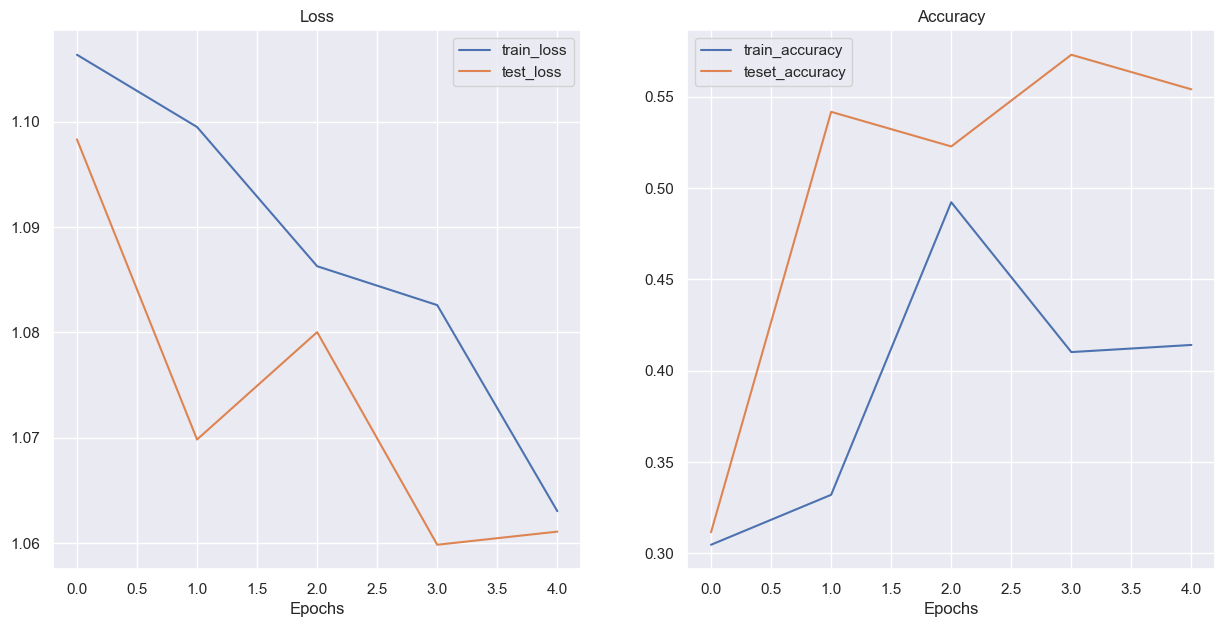

In [54]:
plot_loss_curves(model_0_results)

## TinyVGG with Augmentation

In [56]:
# Create training transform with TrivialAument
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [57]:
# Turn image folders into datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [58]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

tr.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_augmented = DataLoader(dataset=test_data_simple,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       num_workers=NUM_WORKERS)

## Construct and train model 1

In [59]:
tr.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  out_shape=len(train_data_augmented.classes))

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [61]:
tr.manual_seed(42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = tr.optim.Adam(params=model_1.parameters(),
                          lr=0.001)

# Start the timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f'Total training time for model_1: {end_time - start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1046 | Train acc: 0.2500 | Test loss: 1.1016 | Test acc: 0.2604
Epoch: 1 | Train loss: 1.0764 | Train acc: 0.4258 | Test loss: 1.1301 | Test acc: 0.2604
Epoch: 2 | Train loss: 1.0733 | Train acc: 0.4258 | Test loss: 1.1679 | Test acc: 0.2604
Epoch: 3 | Train loss: 1.1220 | Train acc: 0.3047 | Test loss: 1.1551 | Test acc: 0.2604
Epoch: 4 | Train loss: 1.0775 | Train acc: 0.4609 | Test loss: 1.1522 | Test acc: 0.2812
Total training time for model_1: 124.911 seconds


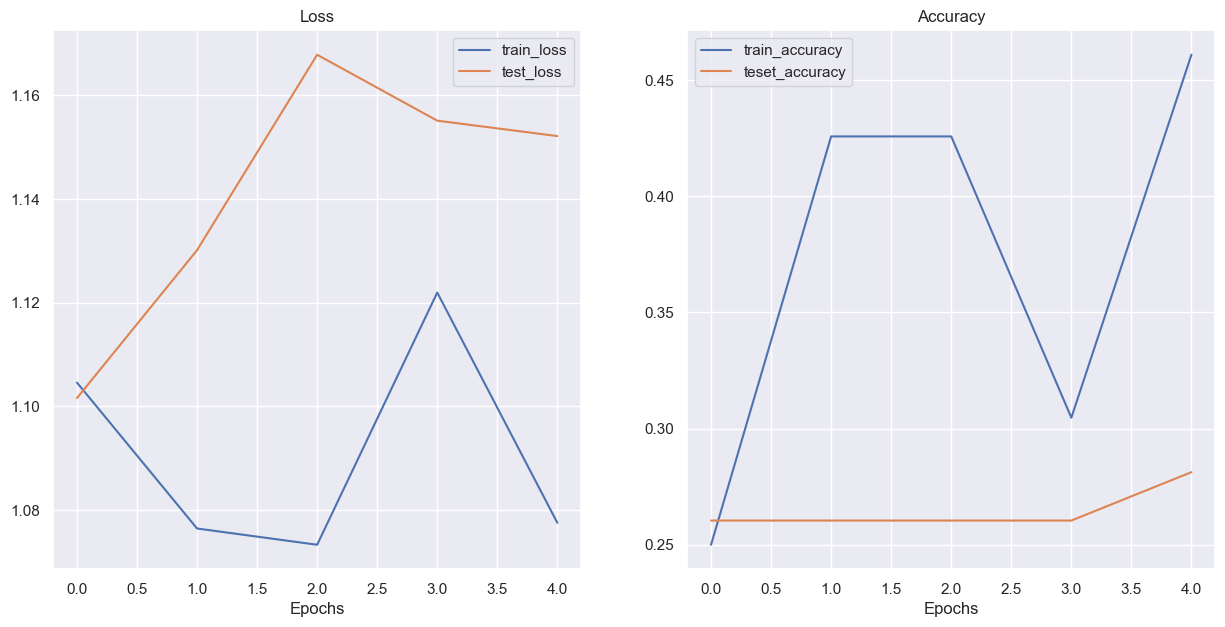

In [62]:
plot_loss_curves(model_1_results)

## Compare model resutls

In [63]:
model_0_df =pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

In [64]:
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106342,0.304688,1.098314,0.311553
1,1.099489,0.332031,1.069841,0.541667
2,1.086282,0.492188,1.080027,0.522727
3,1.082591,0.410156,1.059858,0.572917
4,1.063042,0.414062,1.061103,0.553977


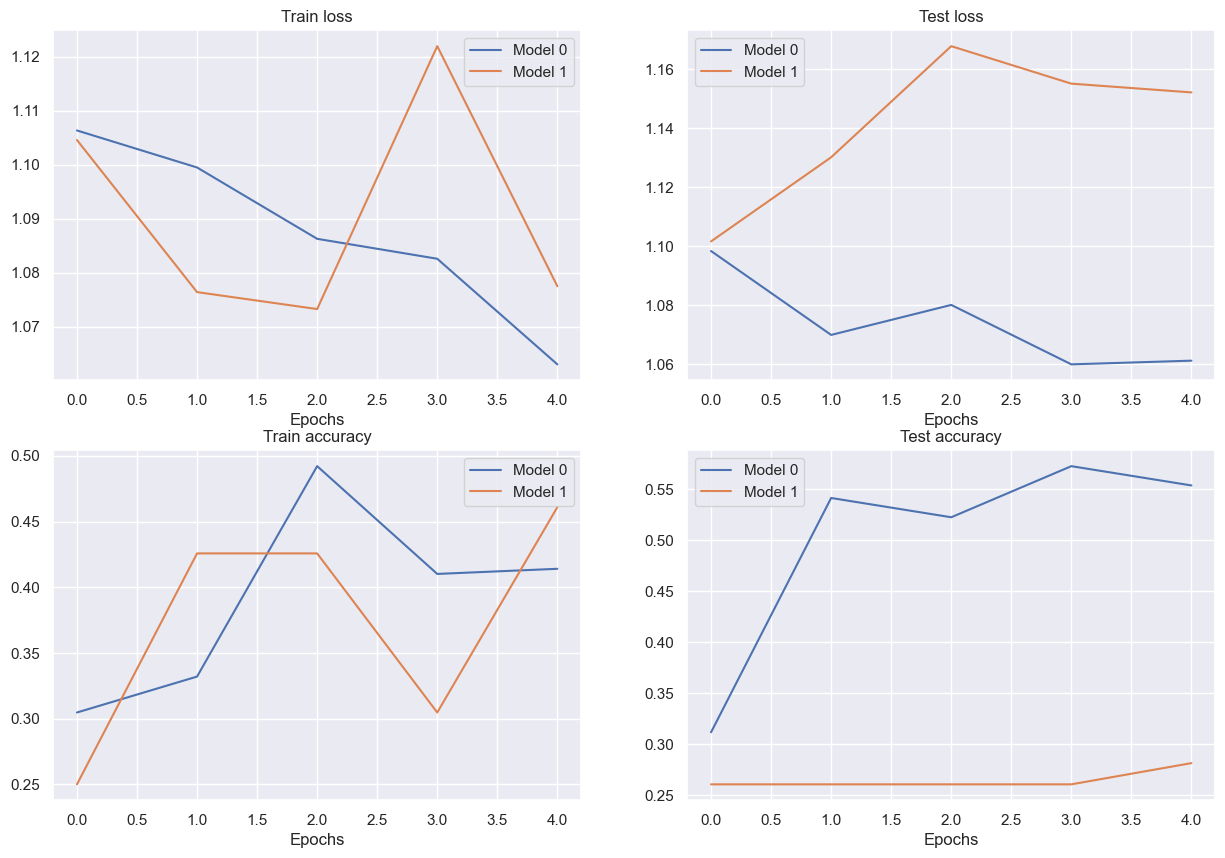

In [68]:
# Setup a plot
plt.figure(figsize=(15,10))

epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df['train_loss'], label='Model 0')
plt.plot(epochs, model_1_df['train_loss'], label='Model 1')
plt.title('Train loss')
plt.xlabel('Epochs')
plt.legend()

# Plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df['test_loss'], label='Model 0')
plt.plot(epochs, model_1_df['test_loss'], label='Model 1')
plt.title('Test loss')
plt.xlabel('Epochs')
plt.legend()

# Plot train accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df['train_acc'], label='Model 0')
plt.plot(epochs, model_1_df['train_acc'], label='Model 1')
plt.title('Train accuracy')
plt.xlabel('Epochs')
plt.legend()

# Plot test accuracy
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df['test_acc'], label='Model 0')
plt.plot(epochs, model_1_df['test_acc'], label='Model 1')
plt.title('Test accuracy')
plt.xlabel('Epochs')
plt.legend()

## Making predictions on a custom image

In [85]:
custom_image_path = Path('data/pizza_steak_sushi/Custom_data/04-pizza-dad.jpeg')

### make sure that our image has the same format that our data was trined on

In [90]:
# Convert iamge to string
custom_image_path_str = str(custom_image_path)
custom_image_uint8 = torchvision.io.read_image(custom_image_path_str)
print(f'Custom image shape: {custom_image_uint8.shape}')
print(f'Custom image datatype {custom_image_uint8.dtype}')

Custom image shape: torch.Size([3, 4032, 3024])
Custom image datatype torch.uint8


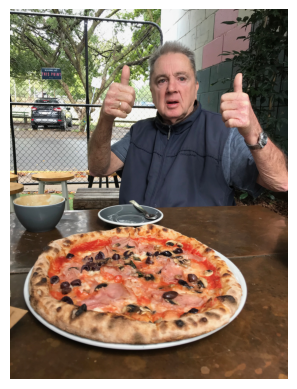

In [89]:
plt.imshow(custom_image_uint8.permute(1,2,0))
plt.axis(False);

## Making a prediction on a custom image with a trained PyTorch model

In [98]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(tr.float32) / 255.

custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])

custom_image_transformed = custom_image_transform(custom_image)

(-0.5, 63.5, 63.5, -0.5)

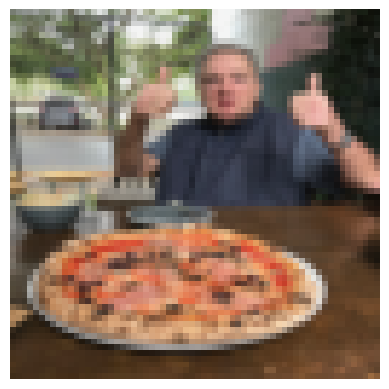

In [100]:
plt.imshow(custom_image_transformed.permute(1,2,0))
plt.axis(False)

In [102]:
model_1.eval()
with tr.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(0))

In [103]:
custom_image_pred

tensor([[ 0.0633,  0.0430, -0.2158]])

In [104]:
# Convert logits -> predictions probabilities
custom_image_pred_probs = tr.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3654, 0.3581, 0.2765]])

In [106]:
# Convert prediciton probabilites -> prediciton labels
custom_image_pred_labels = tr.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_labels

tensor([0])

In [107]:
class_names

['pizza', 'steak', 'sushi']

In [108]:
class_names[custom_image_pred_labels]

'pizza'

In [120]:
CUSTOM_PATH = Path('data/pizza_steak_sushi/Custom_data/04-pizza-dad.jpeg')

def custom_image_predictions(custom_path: str,
                             model: tr.nn.Module,
                             class_names: List[str] = None,
                             transform=None):
    target_image = torchvision.io.read_image(str(custom_path)).type(tr.float32)

    target_image = target_image / 255.

    if transform: 
        target_image = transform(target_image)

        model.eval()
        with tr.inference_mode():
            target_image = target_image.unsqueeze(0)

            target_image_pred = model(target_image)

        target_image_pred_probs = tr.softmax(target_image_pred, dim=1)

        target_image_pred_labels = tr.argmax(target_image_pred_probs, dim=1)

        # Plot the image
        plt.imshow(target_image.squeeze().permute(1,2,0))
        if class_names:
            title = f'Pred: {class_names[target_image_pred_labels.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}'
        else:
            title = f'Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}'
        plt.title(title)
        plt.axis(False)

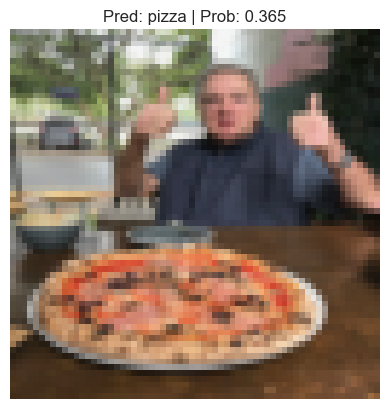

In [121]:
custom_image_predictions(model=model_1,
                         custom_path=custom_image_path,
                         class_names=class_names,
                         transform=custom_image_transform)